In [1]:
%pip install -q torch torchvision pillow huggingface_hub "openvino>=2024.0.0" "matplotlib>=3.4" "gradio>=4.15" "transformers>=4.39.1" tqdm --extra-index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.33.0 requires numpy<2.0.0,>=1.17, but you have numpy 2.1.3 which is incompatible.
neural-compressor 3.0.2 requires numpy<2.0, but you have numpy 2.1.3 which is incompatible.
nncf 2.12.0 requires numpy<1.27,>=1.19.1, but you have numpy 2.1.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.
openvino-dev 2024.3.0 requires numpy<2.0.0,>=1.16.6, but you have numpy 2.1.3 which is incompatible.
openvino-dev 2024.3.0 requires openvino==2024.3.0, but you have openvino 2024.6.0 which is incompatible.
openvino-tokenizers 2024.5.0.0 requires openvino~=2024.5.0.0.dev, but you have openvino 2024.6.0 which is incompatible.
tensorflow-intel 2.17.0 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.1.3 which is incompatible.


In [2]:
from huggingface_hub import hf_hub_download
from pathlib import Path

repo_id = "briaai/RMBG-1.4"

download_files = ["utilities.py", "example_input.jpg"]

for file_for_downloading in download_files:
    if not Path(file_for_downloading).exists():
        hf_hub_download(repo_id=repo_id, filename=file_for_downloading, local_dir=".")

utilities.py:   0%|          | 0.00/980 [00:00<?, ?B/s]

example_input.jpg:   0%|          | 0.00/327k [00:00<?, ?B/s]

In [3]:
from transformers import AutoModelForImageSegmentation

net = AutoModelForImageSegmentation.from_pretrained("briaai/RMBG-1.4", trust_remote_code=True)

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\deepa\.cache\huggingface\hub\models--briaai--RMBG-1.4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


MyConfig.py:   0%|          | 0.00/326 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-1.4:
- MyConfig.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


briarmbg.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-1.4:
- briarmbg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/176M [00:00<?, ?B/s]

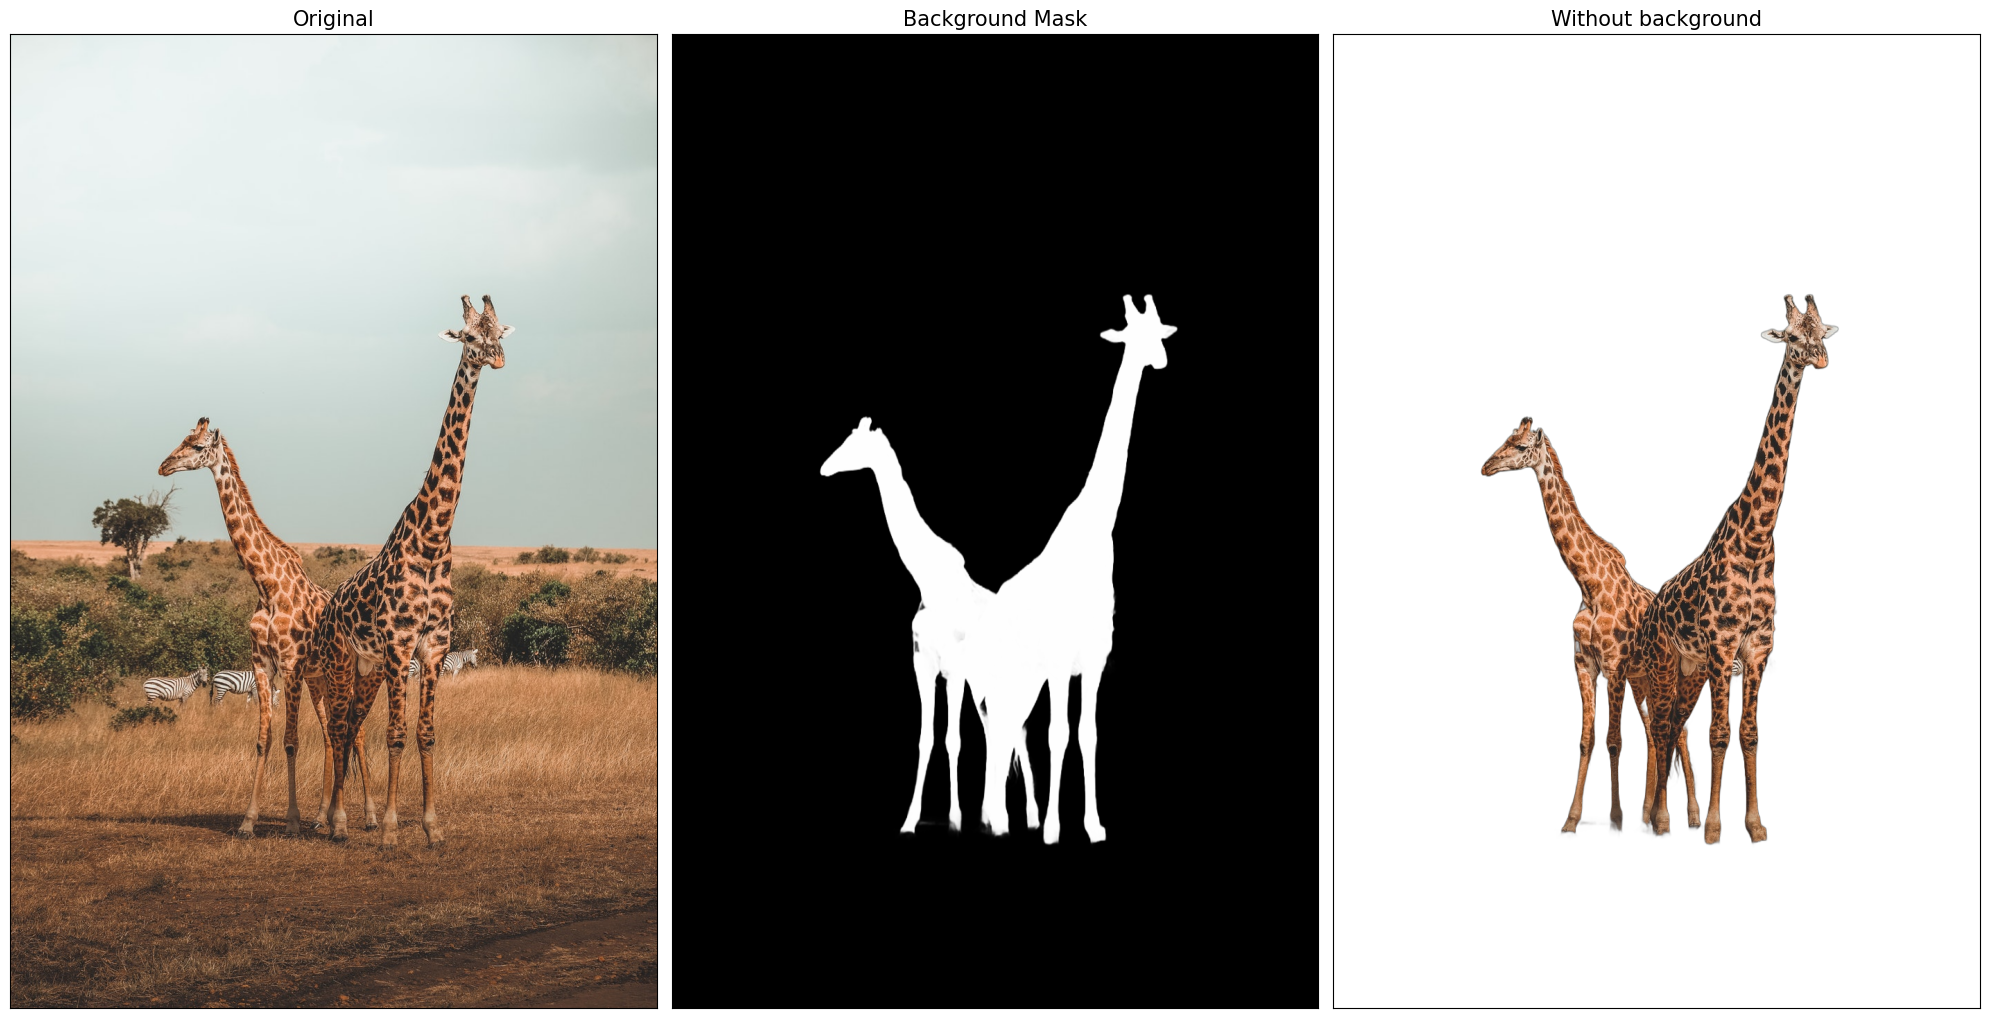

In [4]:
import torch
from PIL import Image
from utilities import preprocess_image, postprocess_image
import numpy as np
from matplotlib import pyplot as plt


def visualize_result(orig_img: Image, mask: Image, result_img: Image):
    """
    Helper for results visualization

    parameters:
       orig_img (Image): input image
       mask (Image): background mask
       result_img (Image) output image
    returns:
      plt.Figure: plot with 3 images for visualization
    """
    titles = ["Original", "Background Mask", "Without background"]
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 20)
    num_images = 3
    fig, axs = plt.subplots(
        num_images if is_horizontal else 1,
        1 if is_horizontal else num_images,
        figsize=figsize,
        sharex="all",
        sharey="all",
    )
    fig.patch.set_facecolor("white")
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(mask), cmap="gray")
    list_axes[0].set_title(titles[0], fontsize=15)
    list_axes[1].set_title(titles[1], fontsize=15)
    list_axes[2].imshow(np.array(result_img))
    list_axes[2].set_title(titles[2], fontsize=15)

    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00, hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    return fig


im_path = "./example_input.jpg"

# prepare input
model_input_size = [1024, 1024]
orig_im = np.array(Image.open(im_path))
orig_im_size = orig_im.shape[0:2]
image = preprocess_image(orig_im, model_input_size)

# inference
result = net(image)

# post process
result_image = postprocess_image(result[0][0], orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
orig_image = Image.open(im_path)
no_bg_image.paste(orig_image, mask=pil_im)
no_bg_image.save("example_image_no_bg.png")

visualize_result(orig_image, pil_im, no_bg_image);

In [5]:
import openvino as ov

ov_model_path = Path("rmbg-1.4.xml")

if not ov_model_path.exists():
    ov_model = ov.convert_model(net, example_input=image, input=[1, 3, *model_input_size])
    ov.save_model(ov_model, ov_model_path)

c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [6]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU', 'NPU', 'AUTO'), value='AUTO')

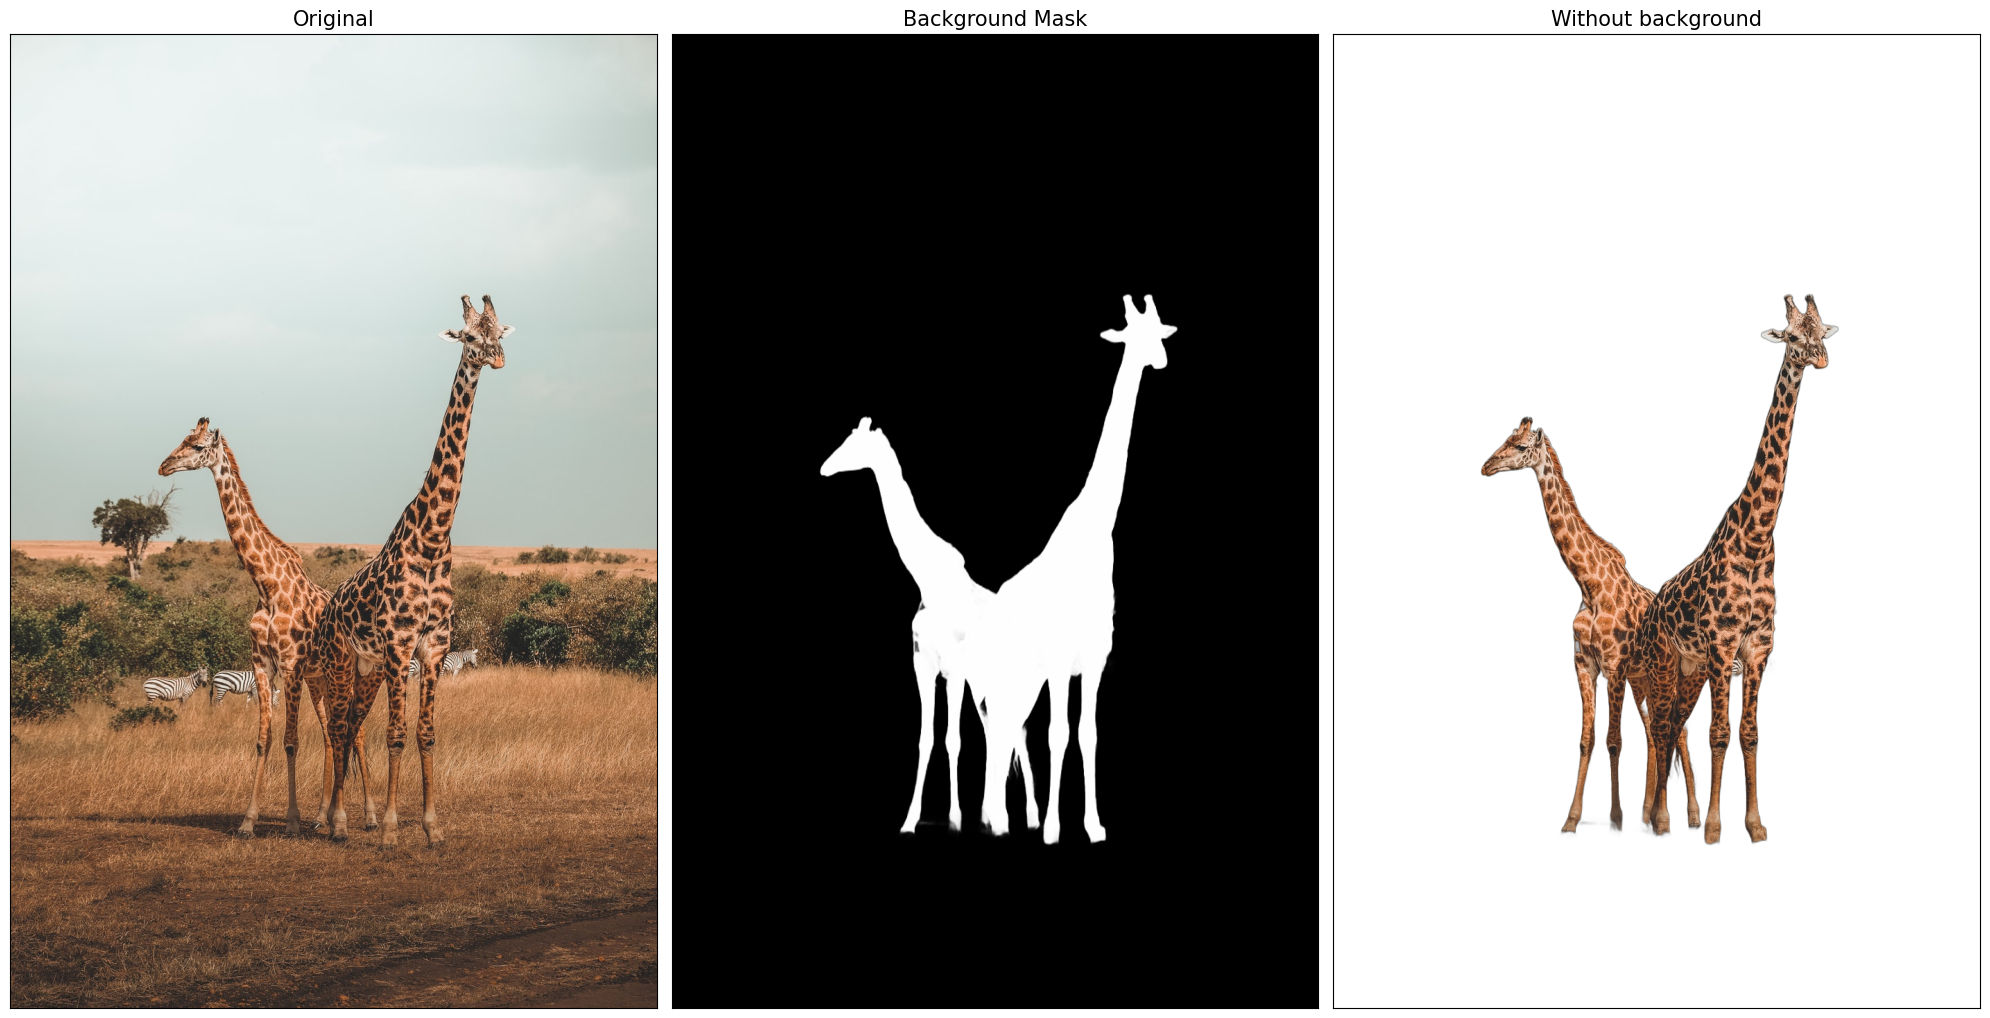

In [9]:
ov_compiled_model = core.compile_model(ov_model_path, device.value)

result = ov_compiled_model(image)[0]

# post process
result_image = postprocess_image(torch.from_numpy(result), orig_im_size)

# save result
pil_im = Image.fromarray(result_image)
no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
orig_image = Image.open(im_path)
no_bg_image.paste(orig_image, mask=pil_im)
no_bg_image.save("example_image_no_bg.png")

visualize_result(orig_image, pil_im, no_bg_image);

In [10]:
def get_background_mask(model, image):
    return model(image)[0]


def on_submit(image):
    original_image = image.copy()

    h, w = image.shape[:2]
    image = preprocess_image(original_image, model_input_size)

    mask = get_background_mask(ov_compiled_model, image)
    result_image = postprocess_image(torch.from_numpy(mask), (h, w))
    pil_im = Image.fromarray(result_image)
    orig_img = Image.fromarray(original_image)
    no_bg_image = Image.new("RGBA", pil_im.size, (0, 0, 0, 0))
    no_bg_image.paste(orig_img, mask=pil_im)

    return no_bg_image

In [ ]:
import requests

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/rmbg-background-removal/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=on_submit)

try:
    demo.launch(debug=False)
except Exception:
    demo.launch(share=True, debug=False)
# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


c:\Users\deepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(
